# Check Colab

In [1]:
try:
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive')
  IN_COLAB = True
except:
  IN_COLAB = False
print(f"am I in Colab? {IN_COLAB}")

am I in Colab? False


# Imports

In [2]:
import os
import sys
import json
import pickle
import shutil
import glob
import re

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tqdm.autonotebook import tqdm, trange

/tmp/ipykernel_3095013/4256873726.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
print(pd.__version__)
print(np.__version__)

2.2.3
1.26.4


In [6]:
from pytube import Playlist
from pytube import Channel
from pytube import YouTube
from youtube_transcript_api import YouTubeTranscriptApi
from pytube.exceptions import PytubeError

from langchain import PromptTemplate


In [7]:
import torch

# Memoria total de la GPU
total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**2  # Convertir a MB

# Memoria utilizada actualmente por PyTorch en la GPU
allocated_memory = torch.cuda.memory_allocated(0) / 1024**2  # Convertir a MB

# Memoria reservada por PyTorch pero no utilizada
cached_memory = torch.cuda.memory_reserved(0) / 1024**2  # Convertir a MB

print(f"Total memory: {total_memory:.2f} MB")
print(f"Allocated memory: {allocated_memory:.2f} MB")
print(f"Cached memory: {cached_memory:.2f} MB")


Total memory: 4031.62 MB
Allocated memory: 0.00 MB
Cached memory: 0.00 MB


In [8]:
!nvidia-smi

Mon Oct 28 19:59:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8             N/A / ERR!  |     621MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Settings

In [9]:
if IN_COLAB:
  # Colab
  BASE_DIR = "."
  BACKUPS_DATA_DIR   = "/content/drive/MyDrive/Colab Notebooks/Dataclub/llm/data"
else:
  # Local
  BASE_DIR = ".."
  BACKUPS_DATA_DIR   = "../backups"

# Local
RAW_DATA_DIR            = f"{BASE_DIR}/data/raw"
PROCESSED_DATA_DIR      = f"{BASE_DIR}/data/processed"
PROCESSED_DOCS_DATA_DIR = f"{BASE_DIR}/data/processed/documents"
PROCESSED_GEN_DATA_DIR  = f"{BASE_DIR}/data/processed/generated"
GENERATED_DATA_DIR      = f"{BASE_DIR}/data/generated"
INFO_DATA_DIR           = f"{BASE_DIR}/data/info"
# Indexing
INDEXING_DATA_DIR = f"{BASE_DIR}/data/indexing"
INDEXING_DOCS_DATA_DIR = f"{BASE_DIR}/data/indexing/documents"
# Tets
TEST_DATA_DIR = f"{BASE_DIR}/data/test"
GROUND_TRUTH_DATA_DIR = f"{BASE_DIR}/data/test/ground_truth"
GROUND_TRUTH_DOCS_DATA_DIR = f"{BASE_DIR}/data/test/ground_truth/documents"
GROUND_TRUTH_GEN_DATA_DIR = f"{BASE_DIR}/data/test/ground_truth/generated"

In [10]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Transformers

In [11]:
from sentence_transformers import SentenceTransformer
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.embeddings import Embeddings

In [12]:
MINILM_EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2'
NMNET_EMBEDDING_MODEL_NAME = 'all-mpnet-base-v2'

In [13]:
model = SentenceTransformer(MINILM_EMBEDDING_MODEL_NAME)

In [14]:
model.max_seq_length

256

In [15]:
embeddings = HuggingFaceEmbeddings(model_name=MINILM_EMBEDDING_MODEL_NAME)

In [16]:
text = "This is a test document."
query_result = embeddings.embed_query(text)

len(query_result), query_result[:10]

(384,
 [-0.0383385568857193,
  0.12346474081277847,
  -0.02864294871687889,
  0.053652726113796234,
  0.008845377713441849,
  -0.03983934223651886,
  -0.07300590723752975,
  0.047771260142326355,
  -0.030462482944130898,
  0.054979778826236725])

# Tiktoken

https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken

In [17]:
import tiktoken

In [18]:
encoding = tiktoken.get_encoding("cl100k_base")

In [19]:
text = "tiktoken is great!"

In [20]:
tokens = encoding.encode(text)
tokens

[83, 1609, 5963, 374, 2294, 0]

In [21]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [22]:
num_tokens_from_string("tiktoken is great!", "o200k_base")

6

## Turn tokens into text with encoding.decode()

In [23]:
text_dec = encoding.decode(tokens)
text_dec

'tiktoken is great!'

In [24]:
text_bytes = [encoding.decode_single_token_bytes(token) for token in tokens]
text_bytes

[b't', b'ik', b'token', b' is', b' great', b'!']

## Comparing encodings

In [25]:
def compare_encodings(example_string: str) -> None:
    """Prints a comparison of three string encodings."""
    # print the example string
    print(f'\nExample string: "{example_string}"')
    # for each encoding, print the # of tokens, the token integers, and the token bytes
    for encoding_name in ["r50k_base", "p50k_base", "cl100k_base", "o200k_base"]:
        encoding = tiktoken.get_encoding(encoding_name)
        token_integers = encoding.encode(example_string)
        num_tokens = len(token_integers)
        token_bytes = [encoding.decode_single_token_bytes(token) for token in token_integers]
        print()
        print(f"{encoding_name}: {num_tokens} tokens")
        print(f"token integers: {token_integers}")
        print(f"token bytes: {token_bytes}")

In [26]:
compare_encodings("antidisestablishmentarianism")


Example string: "antidisestablishmentarianism"

r50k_base: 5 tokens
token integers: [415, 29207, 44390, 3699, 1042]
token bytes: [b'ant', b'idis', b'establishment', b'arian', b'ism']

p50k_base: 5 tokens
token integers: [415, 29207, 44390, 3699, 1042]
token bytes: [b'ant', b'idis', b'establishment', b'arian', b'ism']

cl100k_base: 6 tokens
token integers: [519, 85342, 34500, 479, 8997, 2191]
token bytes: [b'ant', b'idis', b'establish', b'ment', b'arian', b'ism']

o200k_base: 6 tokens
token integers: [493, 129901, 376, 160388, 21203, 2367]
token bytes: [b'ant', b'idis', b'est', b'ablishment', b'arian', b'ism']


# Splitters

https://medium.com/@sushmithabhanu24/retrieval-in-langchain-part-2-text-splitters-2d8c9d595cc9


https://python.langchain.com/docs/how_to/split_by_token/#sentencetransformers


Evaluation:

https://research.trychroma.com/evaluating-chunking


In [27]:
!ls -lh '{RAW_DATA_DIR}' 2>/dev/null | grep '.*\.json$' | head -5

In [28]:
!ls -lh '{PROCESSED_DOCS_DATA_DIR}' 2>/dev/null | grep '.*\.json$' | head -5

-rw-rw-r-- 1 aztleclan aztleclan 3,3K oct 23 17:55 086AnjxzAfg.json
-rw-rw-r-- 1 aztleclan aztleclan 3,0K oct 23 17:55 0iZUayL1RQ0.json
-rw-rw-r-- 1 aztleclan aztleclan 3,1K oct 23 17:55 0X7I-vr2oaM.json
-rw-rw-r-- 1 aztleclan aztleclan 3,1K oct 23 17:55 1WAbPmolGqY.json
-rw-rw-r-- 1 aztleclan aztleclan 3,3K oct 23 17:55 2CxQTUGD-5E.json
grep: write error: Broken pipe


In [29]:
cat "state_of_the_union.txt" | head -4

Madame Speaker, Vice President Biden, members of Congress, distinguished guests, and fellow Americans:

Our Constitution declares that from time to time, the president shall give to Congress information about the state of our union. For 220 years, our leaders have fulfilled this duty. They have done so during periods of prosperity and tranquility. And they have done so in the midst of war and depression; at moments of great strife and great struggle.



## Read documents

In [30]:
# This is a long document we can split up.
with open("state_of_the_union.txt") as f:
    state_of_the_union = f.read()

In [31]:
state_of_the_union[:500]

"Madame Speaker, Vice President Biden, members of Congress, distinguished guests, and fellow Americans:\n\nOur Constitution declares that from time to time, the president shall give to Congress information about the state of our union. For 220 years, our leaders have fulfilled this duty. They have done so during periods of prosperity and tranquility. And they have done so in the midst of war and depression; at moments of great strife and great struggle.\n\nIt's tempting to look back on these moments "

## Langchain

In [32]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import SpacyTextSplitter
#from langchain.text_splitters import SentenceTransformersTextSplitter
from langchain_text_splitters import SentenceTransformersTokenTextSplitter

#from langchain.text_splitters import SentenceTransformersTokenTextSplitter  
#from langchain.text_splitter import SpacyTextSplitter
#from langchain.text_splitter import SentenceTransformersTextSplitter


### tiktoken

In [35]:
from langchain_text_splitters import CharacterTextSplitter

### ChatacterText

In [36]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", chunk_size=100, chunk_overlap=0
)
texts = text_splitter.split_text(state_of_the_union)

Created a chunk of size 123, which is longer than the specified 100
Created a chunk of size 104, which is longer than the specified 100
Created a chunk of size 110, which is longer than the specified 100
Created a chunk of size 109, which is longer than the specified 100
Created a chunk of size 128, which is longer than the specified 100
Created a chunk of size 113, which is longer than the specified 100
Created a chunk of size 118, which is longer than the specified 100
Created a chunk of size 131, which is longer than the specified 100
Created a chunk of size 237, which is longer than the specified 100
Created a chunk of size 176, which is longer than the specified 100
Created a chunk of size 112, which is longer than the specified 100
Created a chunk of size 130, which is longer than the specified 100
Created a chunk of size 116, which is longer than the specified 100
Created a chunk of size 184, which is longer than the specified 100
Created a chunk of size 139, which is longer tha

In [37]:
len(texts), print(texts[0])

Madame Speaker, Vice President Biden, members of Congress, distinguished guests, and fellow Americans:

Our Constitution declares that from time to time, the president shall give to Congress information about the state of our union. For 220 years, our leaders have fulfilled this duty. They have done so during periods of prosperity and tranquility. And they have done so in the midst of war and depression; at moments of great strife and great struggle.


(86, None)

### RecursiveCharacter

In [38]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name="gpt-4",
    chunk_size=100,
    chunk_overlap=0,
)
recursive_texts = text_splitter.split_text(state_of_the_union)

In [39]:
len(recursive_texts), print(recursive_texts[0])

Madame Speaker, Vice President Biden, members of Congress, distinguished guests, and fellow Americans:

Our Constitution declares that from time to time, the president shall give to Congress information about the state of our union. For 220 years, our leaders have fulfilled this duty. They have done so during periods of prosperity and tranquility. And they have done so in the midst of war and depression; at moments of great strife and great struggle.


(120, None)

### TokenTextSplitter

In [40]:
from langchain_text_splitters import TokenTextSplitter

token_text_splitter = TokenTextSplitter(chunk_size=10, chunk_overlap=0)

token_texts = token_text_splitter.split_text(state_of_the_union)

In [41]:
len(token_texts), print(token_texts[0])

Madame Speaker, Vice President Biden, members of


(837, None)

### SentenceTransformers

In [44]:
MODEL_NAME='sentence-transformers/all-mpnet-base-v2'
MODEL_NAME='sentence-transformers/all-mpnet-base-v2'
TOKENS_PER_CHUNK=12

In [46]:

splitter = SentenceTransformersTokenTextSplitter(
    model_name=MODEL_NAME,
    chunk_overlap=0
)
text = "Lorem "

count_start_and_stop_tokens = 2
text_token_count = splitter.count_tokens(text=text) - count_start_and_stop_tokens
print(text_token_count)

2


In [47]:
splitter.maximum_tokens_per_chunk 

384

In [48]:
token_multiplier = splitter.maximum_tokens_per_chunk // text_token_count + 1
print(token_multiplier)

# `text_to_split` does not fit in a single chunk
text_to_split = text * token_multiplier

print(f"tokens in text to split: {splitter.count_tokens(text=text_to_split)}")

193
tokens in text to split: 388


### spaCy

https://spacy.io/usage

In [49]:
from langchain_text_splitters import SpacyTextSplitter

In [50]:
# This is a long document we can split up.
with open("state_of_the_union.txt") as f:
    state_of_the_union = f.read()

In [51]:
text_splitter = SpacyTextSplitter(chunk_size=1000)

texts = text_splitter.split_text(state_of_the_union)
print(texts[0])

Madame Speaker, Vice President Biden, members of Congress, distinguished guests, and fellow Americans:

Our Constitution declares that from time to time, the president shall give to Congress information about the state of our union.

For 220 years, our leaders have fulfilled this duty.

They have done so during periods of prosperity and tranquility.

And they have done so in the midst of war and depression; at moments of great strife and great struggle.



It's tempting to look back on these moments and assume that our progress was inevitable, that America was always destined to succeed.

But when the Union was turned back at Bull Run and the Allies first landed at Omaha Beach, victory was very much in doubt.

When the market crashed on Black Tuesday and civil rights marchers were beaten on Bloody Sunday, the future was anything but certain.

These were times that tested the courage of our convictions and the strength of our union.


/home/aztleclan/.local/share/virtualenvs/zoomcamp-llm-v-cF8mf4/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


# Elastic Search

In [52]:
from datetime import datetime
from elasticsearch import Elasticsearch

In [53]:
es_client = Elasticsearch("http://localhost:9200/")

In [54]:
res = es_client.info()
#print(type(res.body))
print(json.dumps(res.body, indent=4))

{
    "name": "3cfc0904bf39",
    "cluster_name": "docker-cluster",
    "cluster_uuid": "wg43N1DqSdy9g9z_pOLIDQ",
    "version": {
        "number": "8.4.3",
        "build_flavor": "default",
        "build_type": "docker",
        "build_hash": "42f05b9372a9a4a470db3b52817899b99a76ee73",
        "build_date": "2022-10-04T07:17:24.662462378Z",
        "build_snapshot": false,
        "lucene_version": "9.3.0",
        "minimum_wire_compatibility_version": "7.17.0",
        "minimum_index_compatibility_version": "7.0.0"
    },
    "tagline": "You Know, for Search"
}


# Langchain Ollama

In [55]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

In [56]:
%%time
template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

model = OllamaLLM(model="llama3")

chain = prompt | model

chain.invoke({"question": "What is LangChain?"})

CPU times: user 177 ms, sys: 21.7 ms, total: 198 ms
Wall time: 31.1 s


"I love it when people want to approach complex topics in a methodical way!\n\nSo, you're asking me what LangChain is, and I'll start by breaking it down into smaller parts.\n\nFrom my understanding, LangChain is likely related to language models or natural language processing (NLP). Let's see..."

# Embeddings

In [57]:
from tqdm.auto import trange, tqdm

In [58]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("all-mpnet-base-v2")

In [59]:
len(model.encode("This is a simple sentence"))

768

# Test Chucking

In [107]:
from dotenv import load_dotenv
load_dotenv()

True

### Read Template

In [105]:
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [61]:
model_name = 'llama3'
# Template bloks
es_prompt_block_path = '../cooking_recipe_assistant/config/prompts/es_prompt_template_blocks.txt'
en_prompt_block_path = '../cooking_recipe_assistant/config/prompts/en_prompt_template_blocks.txt'
# Template extractions
es_prompt_extracs_path = '../cooking_recipe_assistant/config/prompts/es_prompt_template_extractions.txt'
en_prompt_extracs_path = '../cooking_recipe_assistant/config/prompts/en_prompt_template_extractions.txt'
# Template questions
#es_prompt_extracs_path = '../cooking_recipe_assistant/config/en_prompt_template_questions.txt'
en_prompt_questions_path = '../cooking_recipe_assistant/config/prompts/en_prompt_template_questions.txt'

In [62]:
!ls -lh '{es_prompt_block_path}'

-rw-rw-r-- 1 aztleclan aztleclan 1,5K oct 18 17:24 ../cooking_recipe_assistant/config/prompts/es_prompt_template_blocks.txt


In [63]:
!tail -10 '{es_prompt_block_path}'

...
...


El formato anterior es sólo un ejemplo, no lo incluya en su respuesta.


TRANSCIPCIÓN ORIGINAL:

{transcription}

In [64]:
with open(en_prompt_block_path, 'r') as f:
    en_prompt_template_blocks = f.read()
with open(es_prompt_block_path, 'r') as f:
    es_prompt_template_blocks = f.read()

with open(en_prompt_extracs_path, 'r') as f:
    en_prompt_template_extracs = f.read()
with open(es_prompt_extracs_path, 'r') as f:
    es_prompt_template_extracs = f.read()

with open(en_prompt_questions_path, 'r') as f:
    en_prompt_template_questions = f.read()

In [65]:
print(es_prompt_template_blocks[:1000])

Eres un editor profesional altamente capacitado en ciencia de datos. Tu tarea es convertir una transcripción de una receta de cocina en un texto legible, conservando la mayor cantidad posible de información original.

INSTRUCCIONES:

- Elimina las palabras de relleno, um, eh, ah, mmm, etc.
- Elimina "así que", "como", "cierto", "como" cuando no sean necesarias en el texto y se usen solo como relleno
- Reformula las oraciones para mayor claridad
- Reorganiza las palabras de modo que el resultado sea gramaticalmente correcto
- Si una oración comienza con "y", reformúlala
- Si una oración termina con "¿cierto?", reformúlala - conviértala en una pregunta
- Usa tantas palabras de la oración original como sea posible
- Cuando una idea termina de manera lógica, comience un nuevo párrafo simplemente agregando un salto de línea
- Mantén los párrafos cortos (3-4 oraciones o líneas cada uno) para mejorar la legibilidad
- Siempre sigue el formato provisto y NO AGREGUE ningún formato adicional como

In [66]:
print(en_prompt_template_blocks[:1000])

You are a highly skilled professional editor in data science. Your task is to convert a transcription of a cooking recipe into readable text while preserving as much of the original information as possible.

INSTRUCTIONS:

- Remove filler words, um, eh, ah, mmm, etc.
- Remove "so", "like", "true", "as" when they are not needed in the text and are used only as filler
- Reword sentences for clarity
- Rearrange words so that the result is grammatically correct
- If a sentence starts with "and", reword it
- If a sentence ends with "true?", reword it - turn it into a question
- Use as many words from the original sentence as possible
- When a thought ends logically, start a new paragraph by simply adding a line break
- Keep paragraphs short (3-4 sentences or lines each) to improve readability
- Always follow the format provided and DO NOT ADD any additional formatting such as headings, bold, lists, etc.
- Use only the information provided, do not add any more information.


EXPECTED FORMAT:

In [67]:
print(en_prompt_template_extracs[:1000])

You are a highly skilled professional editor in data science and cooking knowledge.
Your task is to convert a transcription of a cooking recipe into readable text while preserving as much of the original information as possible and extract the following information in JSON format:

INSTRUCTIONS:

- Find a suitable TITLE of the recipe, the original title may contain strange characters and suffer from clickbait.
- Extract the INGREDIENTS of the recipe.
- Extract the INSTRUCTIONS for preparing the recipe. Keep paragraphs short (3-4 sentences or lines each) to improve readability.
- Extract the DESCRIPTION that represents a brief summary of the cooking recipe.
- Extract the TIPS of the recipe (OPTIONAL), such as preparation time, servings, difficulty, etc.
- Always follow the format provided and do not add any additional formatting such as headings, bold, etc.
- Use only the information provided, do not add any additional information.

Please organize the information in the following JSON 

In [68]:
print(es_prompt_template_extracs[:1000])

Eres un editor profesional altamente calificado en ciencia de datos y conocimientos de cocina.
Tu tarea es convertir una transcripción de una receta de cocina en un texto legible mientras conservas la mayor cantidad posible de la información original y extraer la siguiente información en formato JSON:

INSTRUCCIONES:

- Busca un TÍTULO adecuado de la receta.
  * Corrige los errores gramaticales en el título proporcionado.
  * Elimina cualquier elemento de clickbait, asegurándote de que el título sea claro y descriptivo.
- Extrae los INGREDIENTES de la receta.
- Crea las INSTRUCCIONES para preparar la receta en un orden lógico. Mantén los párrafos cortos (3-4 oraciones o líneas cada uno) para mejorar la legibilidad.
- Crea un breve RESUMEN (2-3 oraciones) de la receta que capture su esencia.
- Extrae los TIPS de la receta (OPCIONAL), tales como tiempo de preparación, porciones, dificultad, etc.
- Utiliza únicamente la información proporcionada, no añadas nada más información.
- Genera l

In [69]:
print(en_prompt_template_questions[:1000])

Emulate a user of our cooking assistant app.
Formulate 5 questions that this user might ask based on the cooking recipe.
The record containing the recipe information is as follows:

The record:

TITLE: {title}
INGREDIENTS: {ingredients}
SUMMARY: {summary}
INSTRUCTIONS: {text}
TIPS: {tips}


Given the previous record of a cooking recipe, please:

- Make the questions specific about how to prepare this specific cooking recipe.
- Make the questions specific about the ingredients that need to be used in this specific recipe.
- The questions must contain specific words from the recipe that differentiate it from other recipes.
- "The record" should contain the answer to the generated questions.
- The questions should be complete and not too short.
- Use as fewer words as possible from the record.
- Don't generate the answers to the questions.


Provide the result in parsable JSON format without using code blocks. Do not generate solutions with additional text or json-style comments. Make sur

In [70]:
#gen_format_dir = f"{GENERATED_DATA_DIR}/format"
gen_blocks_dir = f"{PROCESSED_GEN_DATA_DIR}/blocks"
gen_extras_dir = f"{PROCESSED_GEN_DATA_DIR}/extractions"
gen_template_extras_dir = f"{PROCESSED_GEN_DATA_DIR}/template_extractions"
#os.makedirs(gen_extras_dir, exist_ok=True)
#os.makedirs(gen_template_extras_dir, exist_ok=True)


In [71]:
!ls -lh "{gen_extras_dir}"

total 1,6M
-rw-rw-r-- 1 aztleclan aztleclan 2,2K oct 23 17:55 086AnjxzAfg.json
-rw-rw-r-- 1 aztleclan aztleclan 2,2K oct 21 02:18 086AnjxzAfg.txt
-rw-rw-r-- 1 aztleclan aztleclan 2,0K oct 23 17:55 0iZUayL1RQ0.json
-rw-rw-r-- 1 aztleclan aztleclan 2,0K oct 21 12:38 0iZUayL1RQ0.txt
-rw-rw-r-- 1 aztleclan aztleclan 2,0K oct 23 17:55 0X7I-vr2oaM.json
-rw-rw-r-- 1 aztleclan aztleclan 2,0K oct 21 12:38 0X7I-vr2oaM.txt
-rw-rw-r-- 1 aztleclan aztleclan 2,0K oct 23 17:55 1WAbPmolGqY.json
-rw-rw-r-- 1 aztleclan aztleclan 2,1K oct 21 12:38 1WAbPmolGqY.txt
-rw-rw-r-- 1 aztleclan aztleclan 2,2K oct 23 17:55 2CxQTUGD-5E.json
-rw-rw-r-- 1 aztleclan aztleclan 2,3K oct 21 12:38 2CxQTUGD-5E.txt
-rw-rw-r-- 1 aztleclan aztleclan 1,9K oct 23 17:55 2JkGOfXAgq4.json
-rw-rw-r-- 1 aztleclan aztleclan 1,9K oct 21 02:16 2JkGOfXAgq4.txt
-rw-rw-r-- 1 aztleclan aztleclan 2,0K oct 23 17:55 2xNYwpXK02c.json
-rw-rw-r-- 1 aztleclan aztleclan 2,1K oct 21 02:17 2xNYwpXK02c.txt
-rw-rw-r-- 1 aztleclan aztleclan 2,5K oct 23

In [75]:
video_texts = {}
video_tokens = {}
video_text_lengths = {}
video_token_lengths = {}
video_objects = {}

encoding = tiktoken.get_encoding("cl100k_base")
blocks_count = 0
extrac_count = 0
pattern = r'```json\n(.*?)```'
for file in glob.glob(f"{RAW_DATA_DIR}/documents/*.json"):
    # Read document
    with open(file, 'r') as f:
        doc = json.load(f)
    
    # Data
    video_id = doc['video_id']
    title = doc['title']
    length = doc['length']

    # Skip filles
    if (length < 60 * 4.9) or (length > 60 * 15):  # 60 segundos equivalen a 1 minuto
        continue
    
    # Read extractions
    recipe_extrac_path = f"{gen_extras_dir}/{video_id}.txt"
    with open(recipe_extrac_path, 'r') as f:
        generated_extraction_text = f.read()
    # Buscar el JSON en el texto
    match = re.search(pattern, generated_extraction_text, re.DOTALL)
    if match:
        json_extraction_content = match.group(1).strip()
        json_extraction_object = json.loads(json_extraction_content)
        #print(json_content)
    else:
        print("No se encontró JSON.")
    # Build data
    #recipe_data = json_extraction_object
    #recipe_data['video_id']
    instructions = json_extraction_object['instructions']
    instructions_text = ''.join(instructions)
    instructions_tokens = encoding.encode(instructions_text)
    video_texts[video_id] = instructions_text
    video_tokens[video_id] = instructions_tokens
    video_text_lengths[video_id] = len(instructions_text)
    video_token_lengths[video_id] = len(instructions_tokens)
    video_objects[video_id] = json_extraction_object

### Drawing

In [76]:
# Convertir a DataFrame y ordenar
tokens_df = pd.DataFrame(list(video_token_lengths.items()), columns=['video_id', 'token_num'])
tokens_df = tokens_df.sort_values(by='token_num', ascending=False)

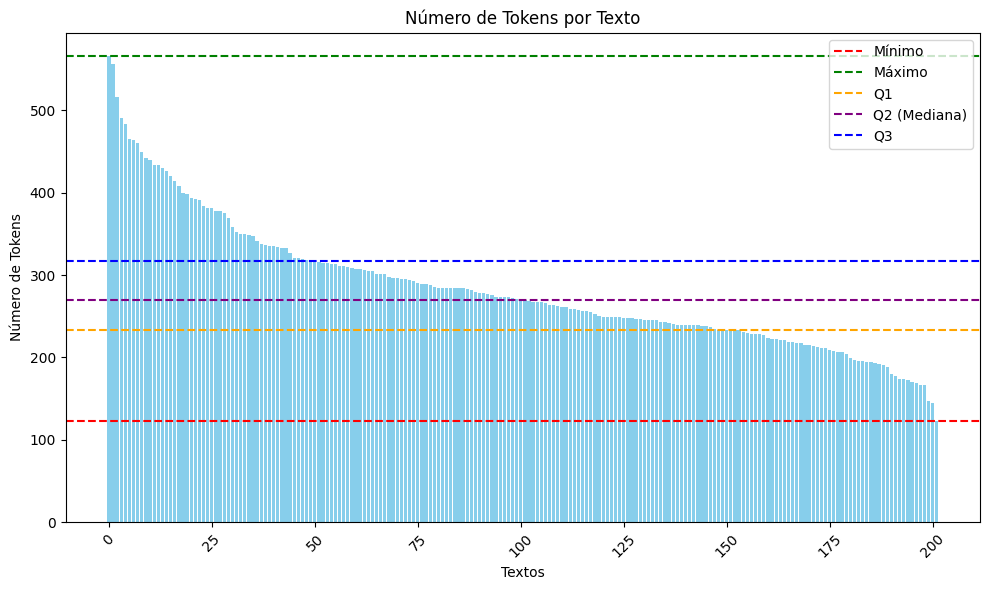

max: 566, Q1: 233.25, mediana: 270.0, Q3: 316.75, min: 123


In [77]:
# Extrae los valores y ordénalos de manera descendente
#token_values = sorted(video_tokens.values(), reverse=True)
token_lengths = tokens_df['token_num']

# Calcula los cuartiles
#q1 = np.percentile(token_values, 25)
#q2 = np.percentile(token_values, 50)
#q3 = np.percentile(token_values, 75)
#minimum = min(token_values)
#maximum = max(token_values)
qs = token_lengths.quantile([.25, .5, .75])
q1 = qs.iloc[0]
q2 = qs.iloc[1]
q3 = qs.iloc[2]
minimum = token_lengths.min()
maximum = token_lengths.max()

# Crea la gráfica
plt.figure(figsize=(10, 6))
plt.bar(range(len(token_lengths)), token_lengths, color='skyblue')
#plt.xticks(range(len(token_values)), list(tokens.keys()), rotation=45)
plt.xticks(rotation=45)

# Dibuja líneas para el mínimo, máximo y cuartiles
plt.axhline(y=minimum, color='red', linestyle='--', label='Mínimo')
plt.axhline(y=maximum, color='green', linestyle='--', label='Máximo')
plt.axhline(y=q1, color='orange', linestyle='--', label='Q1')
plt.axhline(y=q2, color='purple', linestyle='--', label='Q2 (Mediana)')
plt.axhline(y=q3, color='blue', linestyle='--', label='Q3')

plt.title('Número de Tokens por Texto')
plt.xlabel('Textos')
plt.ylabel('Número de Tokens')
plt.legend()
plt.tight_layout()
plt.show()

print(f"max: {maximum}, Q1: {q1}, mediana: {q2}, Q3: {q3}, min: {minimum}")

In [78]:
print(f'[max({maximum}), q3({q3})] -> {sum(tokens_df.token_num >= q3)}')
print(f'(q3({q3}), q2({q2})]-> {sum((tokens_df.token_num < q3) & (tokens_df.token_num >= q2))}')
print(f'(q2({q2}), q1({q1})]-> {sum((tokens_df.token_num < q2) & (tokens_df.token_num >= q1))}')
print(f'(q1({q1}), min({minimum})] -> {sum((tokens_df.token_num < q1))}')

[max(566), q3(316.75)] -> 51
(q3(316.75), q2(270.0)]-> 51
(q2(270.0), q1(233.25)]-> 49
(q1(233.25), min(123)] -> 51


In [79]:
tokens_df[tokens_df.token_num >= q3].head(5)

,video_id,token_num
104,ebaB3psaU2I,566
139,pc8Cpod7CSk,556
10,yDbVm5PgAkA,516
22,mG1TZMoGuTA,491
14,f7XG2heS1s4,484


In [80]:
tokens_df[((tokens_df.token_num < q3) & (tokens_df.token_num >= q2))].head(5)

,video_id,token_num
127,wrLRanBn_Rs,316
194,GgeOY65yZsA,315
180,tLRg4teKPXA,315
145,aZAk-6SGLPw,314
126,ZogtJ9z8UBg,314


In [81]:
tokens_df[((tokens_df.token_num < q2) & (tokens_df.token_num >= q1))].head(5)

,video_id,token_num
147,2xNYwpXK02c,269
6,DCfe0mdpr4c,268
85,c1j-LBkrz0Y,267
181,2CxQTUGD-5E,267
161,9998E5izQwc,266


In [82]:
tokens_df[(tokens_df.token_num < q1)].head(5)

,video_id,token_num
176,ibQRhYp55DA,233
124,Lm4uCq28kbU,233
101,3k4H4Aw0GwE,233
133,F6vWWpBZe4o,231
123,bJNsrRWbnug,230


### SentenceTransformersTokenTextSplitter

In [83]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer

In [84]:
maxq3_video_id  = tokens_df[tokens_df.token_num >= q3].iloc[0].video_id
q3q2_video_id   = tokens_df[((tokens_df.token_num < q3) & (tokens_df.token_num >= q2))].iloc[0].video_id
q2q1_video_id   = tokens_df[((tokens_df.token_num < q2) & (tokens_df.token_num >= q1))].iloc[0].video_id
q1min_video_id  = tokens_df[tokens_df.token_num < q1].iloc[0].video_id  

recetas = [
    {'video_id': maxq3_video_id, 'text': video_texts[maxq3_video_id]},
    {'video_id': q3q2_video_id,  'text': video_texts[q3q2_video_id]},
    {'video_id': q2q1_video_id,  'text': video_texts[q2q1_video_id]},
    {'video_id': q1min_video_id, 'text': video_texts[q1min_video_id]}
]

In [85]:
def get_documents():
    recipes = ({'video_id':video_id, 'text':text} for video_id, text in video_texts.items())
    return recipes

In [86]:
# Configuración para SentenceTransformersTokenTextSplitter
st_chunk_size = 150  # Tamaño del chunk
st_chunk_overlap = 50  # Superposición

# Inicializar SentenceTransformersTokenTextSplitter
sentence_splitter = SentenceTransformersTokenTextSplitter(
    chunk_size=st_chunk_size,
    chunk_overlap=st_chunk_overlap,
)


# Función para chunkear recetas usando SentenceTransformersTokenTextSplitter
def chunk_recetas_sentence(recipes):
    recipes_with_chunks_st = []
    for recipe in recipes:
        recipe_chunks = sentence_splitter.split_text(recipe['text'])
        #doc = {
        #    'doc_id': receta['video_id'],
        #    'text': receta['video_id'],
        #    'chunks': receta_chunks
        #}
        #recipies_with_chunks.append(doc)
        recipe_st = dict(recipe)
        recipe_st['chunks'] = recipe_chunks
        recipes_with_chunks_st.append(recipe_st)
    return recipes_with_chunks_st

In [87]:
%%time
# Obtener los chunks con SentenceTransformers
recipes_with_chunks_st = chunk_recetas_sentence(get_documents())

CPU times: user 521 ms, sys: 0 ns, total: 521 ms
Wall time: 524 ms


In [88]:
# Mostrar los chunks
print("Chunks de SentenceTransformersTokenTextSplitter:")
for doc in recipes_with_chunks_st:
    for i, chunk in enumerate(doc['chunks']):
        print(f"id: {doc['video_id']}, Chunk {i + 1}: {chunk[:50]}\n")

Chunks de SentenceTransformersTokenTextSplitter:
id: sY6_tPHGTcA, Chunk 1: season the beef with salt and pepper. dust the bee

id: rWFjtWxZ5NY, Chunk 1: fry the bacon in a pan without oil until crispy. o

id: FvLoIdoWfBs, Chunk 1: heat oil in a pan over medium heat and add the cho

id: TSLTGxGqnqY, Chunk 1: cover the interior of a mold with transparent wrap

id: ngkThalWi4I, Chunk 1: heat a generous amount of olive oil in a medium po

id: EsaZ0lBQt2I, Chunk 1: preheat the oven to 150 degrees celsius. in a bowl

id: DCfe0mdpr4c, Chunk 1: heat a splash of olive oil in a skillet to sear th

id: 70YJ92Ke4fM, Chunk 1: peel the outer skin of the onion and slice it thin

id: 70YJ92Ke4fM, Chunk 2: garlic and a couple of cayenne peppers. cook until

id: geuh5XuqzKE, Chunk 1: in a pot, combine water, a splash of oil, salt, an

id: 0X7I-vr2oaM, Chunk 1: start by spreading a generous layer of pate on one

id: yDbVm5PgAkA, Chunk 1: to prepare the fish broth, heat a generous splash 

id: yDbVm5PgAkA

In [89]:
type(recipes_with_chunks_st[0]['chunks']), type(recipes_with_chunks_st[1]['chunks']), 

(list, list)

In [90]:
# Cargar el modelo para embeddings
#embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Función para calcular embeddings
def calculate_embeddings(recipes):
    for recipe in recipes:
        #receta['embeddings'] = [embedding_model.encode(chunk) for chunk in receta['chunks']]
        recipe['embeddings'] = embedding_model.embed_documents(recipe['chunks'])
    return recipes

In [91]:
%%time
# Obtener embeddings
recipes_with_chunks_st = calculate_embeddings(recipes_with_chunks_st)

CPU times: user 2.44 s, sys: 58 µs, total: 2.44 s
Wall time: 2.57 s


In [92]:
len(recipes_with_chunks_st)

202

In [93]:
for recipe in recipes_with_chunks_st:
    for i, embedding in enumerate(recipe['embeddings']):
        print(f"id: {recipe['video_id']}, Chunk {i + 1}: {embedding[:10]}\n")

id: sY6_tPHGTcA, Chunk 1: [-0.03982061520218849, -0.02925357036292553, -0.008489222265779972, 0.03419112414121628, -0.08029104769229889, -0.07178275287151337, -0.07253165543079376, 0.00964454747736454, 0.035387344658374786, -0.08738440275192261]

id: rWFjtWxZ5NY, Chunk 1: [-0.010408814065158367, -0.022361842915415764, -0.059148725122213364, -0.020344272255897522, -0.10830278694629669, -0.09905030578374863, -0.05338997021317482, -0.015232812613248825, -0.03740830346941948, -0.05877704545855522]

id: FvLoIdoWfBs, Chunk 1: [-0.052395861595869064, 0.013898417353630066, -0.021504780277609825, 0.003684350987896323, -0.0494346059858799, -0.05889945477247238, -0.04621683433651924, 0.023498717695474625, -0.015645576640963554, -0.049863796681165695]

id: TSLTGxGqnqY, Chunk 1: [0.01313511561602354, 0.05840856954455376, 0.03426196426153183, -0.008196585811674595, -0.08161573112010956, 0.0249930452555418, -0.0805104449391365, 0.01775396429002285, 0.01293270755559206, 0.0031984965316951275]

id: ngk

### RecursiveCharacter

In [94]:
# Configuración para RecursiveCharacterTextSplitter
rc_chunk_size = 250  # Tamaño del chunk
rc_chunk_overlap = 50  # Superposición

# Inicializar RecursiveCharacterTextSplitter
recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size=rc_chunk_size,
    chunk_overlap=rc_chunk_overlap,
)

# Función para chunkear recetas usando RecursiveCharacterTextSplitter
def chunk_recetas_recursive(recipes):
    recipies_with_chunks_rc = []
    for recipe in recipes:
        receta_chunks = recursive_splitter.split_text(recipe['text'])
        #chunks.extend(receta_chunks)
        recipe_rc = dict(recipe)
        recipe_rc['chunks'] = receta_chunks
        recipies_with_chunks_rc.append(recipe_rc)
    #return chunks
    return recipies_with_chunks_rc

In [95]:
%%time
# Obtener los chunks con RecursiveCharacterTextSplitter
recipes_with_chunks_rc = chunk_recetas_recursive(get_documents())

CPU times: user 98.8 ms, sys: 127 µs, total: 98.9 ms
Wall time: 96.5 ms


In [96]:
len(recipes_with_chunks_rc)

202

In [97]:
# Mostrar los chunks
print("Chunks de RecursiveCharacterTextSplitter:")
for recipe in recipes_with_chunks_rc:
    for i, chunk in enumerate(recipe['chunks']):
        print(f"ID: {recipe['video_id']}, Chunk {i + 1}: {chunk}\n")

Chunks de RecursiveCharacterTextSplitter:
ID: sY6_tPHGTcA, Chunk 1: Season the beef with salt and pepper. Dust the beef with flour and remove excess.Heat olive oil in a pot and brown the floured beef to seal in the juices. Once browned, remove the beef and set aside.In the same pot, sauté the onions and carrots over

ID: sY6_tPHGTcA, Chunk 2: the same pot, sauté the onions and carrots over medium heat with a pinch of salt until the onions are translucent, about 10 minutes.Stir in 2-3 tablespoons of tomato concentrate and mix for 5 seconds.Return the beef to the pot along with its juices,

ID: sY6_tPHGTcA, Chunk 3: the beef to the pot along with its juices, then add red wine and water (double the amount of water to wine).Add 2 teaspoons of Herbes de Provence and bring to a boil. Once boiling, cover and reduce heat to medium (5-6 out of 9).Cook until the beef

ID: sY6_tPHGTcA, Chunk 4: heat to medium (5-6 out of 9).Cook until the beef is tender, about 1 to 1.5 hours, stirring occasionall

In [98]:
%%time
# Obtener embeddings
recipes_with_chunks_rc = calculate_embeddings(recipes_with_chunks_rc)

CPU times: user 2.96 s, sys: 2.27 ms, total: 2.97 s
Wall time: 2.98 s


In [99]:
for recipe in recipes_with_chunks_rc:
    for i, embedding in enumerate(recipe['embeddings']):
        print(f"id: {recipe['video_id']}, Chunk {i + 1}: {embedding[:10]}\n")

id: sY6_tPHGTcA, Chunk 1: [-0.024373266845941544, 0.013423589058220387, 0.018175683915615082, 0.015016602352261543, -0.02373681403696537, -0.02520100027322769, -0.0864248126745224, -0.01492392085492611, -0.00974317267537117, -0.07288471609354019]

id: sY6_tPHGTcA, Chunk 2: [-0.014511775225400925, -0.02037176862359047, -0.0391559973359108, 0.05084008350968361, -0.0686631128191948, -0.005855378694832325, -0.08099033683538437, -0.02135150320827961, 0.02091274783015251, -0.061049122363328934]

id: sY6_tPHGTcA, Chunk 3: [0.011811941862106323, -0.002186954952776432, -0.02396123670041561, 0.025332843884825706, -0.09137428551912308, -0.007755849044770002, -0.04500235244631767, 0.00040587701369076967, -0.012065370567142963, -0.056963030248880386]

id: sY6_tPHGTcA, Chunk 4: [-0.003913256339728832, -0.04227324202656746, -0.012323553673923016, 0.06865084171295166, -0.07211484760046005, -0.1234699934720993, -0.07312225550413132, -0.012444539926946163, 0.024507999420166016, -0.06386005878448486]

id

## Analize Chunks

In [100]:
!ls -lh "{PROCESSED_DOCS_DATA_DIR}" 2>/dev/null | head -5

total 944K
-rw-rw-r-- 1 aztleclan aztleclan 3,3K oct 23 17:55 086AnjxzAfg.json
-rw-rw-r-- 1 aztleclan aztleclan 3,0K oct 23 17:55 0iZUayL1RQ0.json
-rw-rw-r-- 1 aztleclan aztleclan 3,1K oct 23 17:55 0X7I-vr2oaM.json
-rw-rw-r-- 1 aztleclan aztleclan 3,1K oct 23 17:55 1WAbPmolGqY.json


In [101]:
blocks_count = 0
extrac_count = 0
video_chunks = {}
pattern = r'```json\n(.*?)```'
for file in glob.glob(f"{PROCESSED_DOCS_DATA_DIR}/*.json"):
    # Read document
    with open(file, 'r') as f:
        doc = json.load(f)
    doc_id = doc['doc_id']
    video_chunks[doc_id] = len(doc['chunks'])
        

In [102]:
# Convertir a DataFrame y ordenar
chunks_df = pd.DataFrame(list(video_chunks.items()), columns=['video_id', 'chunk_num'])
chunks_df = chunks_df.sort_values(by='chunk_num', ascending=False)

/tmp/ipykernel_3095013/2754260273.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


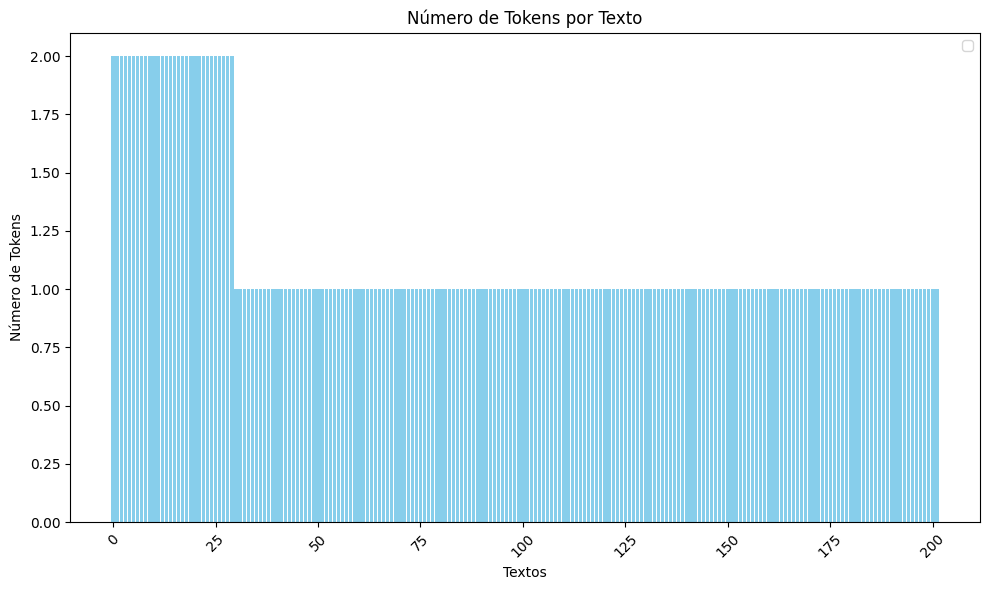

In [103]:
chunk_lengths = chunks_df['chunk_num']

# Crea la gráfica
plt.figure(figsize=(10, 6))
plt.bar(range(len(chunk_lengths)), chunk_lengths, color='skyblue')
#plt.xticks(range(len(token_values)), list(tokens.keys()), rotation=45)
plt.xticks(rotation=45)


plt.title('Número de Tokens por Texto')
plt.xlabel('Textos')
plt.ylabel('Número de Tokens')
plt.legend()
plt.tight_layout()
plt.show()